# Assessing Trends in Fishing Effort Inside and Outside Peru's EEZ Using AIS Data from Global Fishing Watch.

#### Authors
- Jessica French 
  jfrench@bren.ucsb.edu
  
- Javier Patrón 
  jpatron@bren.ucsb.edu

- Pol Carbó Mestre
  pcarbomestre@bren.ucsb.edu

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display](#display)

[5. Use Case Example](#usecases)

[6. Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
## Notebook Purpose

The purpose of this notebook is to explore Global Fishing Watch's dataset showing daily fishing effort as inferred fishing hours daily. This notebook will show how to read in the dataset, visualize the data using google earth engine, and give an overview of how the data can be used to explore differences in fishing effort within and outside Peru's EEZ and how fishing effort is impacted by El Niño Southern Oscillation (ENSO) events. 


<a id='overview'></a> 
## Dataset Description

The Global Fishing Watch (GFW) provides an open platform to access Automatic Identification System (AIS) data from commercial fishing activities. The AIS is a tracking system that uses transceivers on ships to broadcast vessel information such as unique identification, position, course, and speed. AIS is integrated into all classes of vessels as a collision avoidance tool. However, the GFW collects and processes raw AIS data related to fishing activities to improve records and assign additional information, such as the distance from shore, depth, etc. Then, with the use of machine learning models, they characterize vessels and fishing activities, which constitute some of the products available in their [API](https://globalfishingwatch.org/our-apis/documentation#introduction).

One of the most interesting products that the GFW API offers is estimates of fishing effort derived from AIS data. GFW uses machine learning models to classify fishing vessels and predict when they are fishing. First, they identify fishing vessels in the AIS system. Then the vessel is characterized using the best available information and their fleet registry data combined with a characterization model trained on 45,441 marine vessels (both fishing and non-fishing) matched to official fleet registries. Then, GFW estimates the vessel's fishing time and location based on its movement patterns. To do so, a fishing detection model was trained on AIS data from 503 ships and identified fishing activity with >90% accuracy. The model predicts a score for every AIS position in their database to distinguish fishing positions from non-fishing positions (i.e., navigation time). When the model identifies fishing activity, the time associated with that AIS position is registered as apparent fishing activity. More details about the model can be found on the following GitHub repository ([link](https://github.com/GlobalFishingWatch/vessel-scoring/blob/master/notebooks/Model-Descriptions.ipynb)).


<img src="img/img1.png" alt="Drawing" class="center" style="display: inline-block;
  margin-left: auto;
  margin-right: auto;
  height: 300px;" />
<img src="img/img2.png" alt="Drawing" class="center" style="display: inline-block;
  margin-left: auto;
  margin-right: auto;
  height: 300px;" />


Once the fishing vessels are identified and their AIS positions have been assigned as fishing positions, the apparent fishing effort can be calculated for any area by summarizing the fishing hours for all fishing vessels in that area. The resulting maps of apparent fishing effort are created by rasterizing all AIS positions into a grid and calculating the total fishing activity in each grid cell. For the present project we will access this type processed data.

<img src="img/img3.png" alt="Drawing" class="center" style="display: block;
  margin-left: auto;
  margin-right: auto;
  height: 300px;">

Pre-processed AIS data can be accessed from their [R package "gfwr"](https://github.com/GlobalFishingWatch/gfwr) or downloaded from their [website](https://globalfishingwatch.org/data-download/) as .cvs files. For this project, we will use some of their existing products related to fishing effort. The data can be accessed from [Google Big Query](https://globalfishingwatch.org/data/our-data-in-bigquery/) in a less processed format and through Google Earth Engine (GEE) for two data subproducts [daily fishing hours](https://developers.google.com/earth-engine/datasets/catalog/GFW_GFF_V1_fishing_hours) and [daily vessel hours](https://developers.google.com/earth-engine/datasets/catalog/GFW_GFF_V1_vessel_hours#image-properties). For accessibility reasons, we will focus on the GEE data related to fishing hours.

Each image in the collection contains daily rasters of fishing effort measured in hours of inferred fishing activity per square kilometer. Data is available for a given flag state and day, over a 5 years period (2012-2017), where each band represent a fishing gear type. The following figure summarizes the image resolution and the available bands.

<img src="img/img4.png" alt="Drawing" class="center" style="display: block;
  margin-left: auto;
  margin-right: auto;
  height: 300px;">

The data used belongs to the [first global assessment of commercial fishing activity](https://www.science.org/doi/full/10.1126/science.aao5646), published in Science by GFW (2018). 

<a id='io'></a> 
## Dataset Input/Output 

Load in necessary packages.

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import chain
import os

Authenticate and initialize google earth engine.

In [2]:
# Authenticate google earth engine
#ee.Authenticate()
# Initialize google earth engine 
ee.Initialize()

Read in the data from google earth engine and filter metadata to include all countries.

In [3]:
# Read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')

# Filter by "WLD" to get all global fishing vessel hours. This includes all countries in the dataset. 
fishing_effort_ImgCollection = dataset.filterMetadata('country', 'equals', 'WLD')

# SRTM data to use for background in the gif.
SRTM=ee.Image("USGS/GTOPO30")

We define two areas of interest (AOI) for the time series analysis. The first one relative to the EEZ of Peru stored `data/eez_peru/geojson/eez_peru.geojson`. The second AOI is a square area comprizing the EEZ and the neigboring waters in the west. We chose to focus on the area of Peru's coast that includes two of the largest fishing ports, Paita and Callao. 

In [4]:
# Read in EEZ geometry of Peru 
with open('data/eez_peru/geojson/eez_peru.geojson') as f:
  geojson = json.load(f)
coords = geojson["features"][0]["geometry"]["coordinates"]
## The resulting List from the geojson file has an extra bracket that we have to remove to be read it as a polygon
aoi_1 = ee.Geometry.Polygon([i for i in chain.from_iterable(coords)])

In [5]:
# Defining new AOI including areas beyond the EEZ
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -89.8703470212856,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -2.9010789371311176
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geojson["features"][0]["geometry"]["coordinates"]
aoi_2 = ee.Geometry.Polygon(coords)

Define visualization parameters.

In [6]:
# Define color palette for visualizations
trawlersVis = {
  'palette': ['0C276C', '3B9088', 'EEFF00', 'ffffff']
}

In [7]:
# Define video parameters
videoArgs = {
    'dimensions': 670,
    'region': aoi_2,
    'framesPerSecond': 4,
    'crs': 'EPSG:4326',
    'min': 0.0,
    'max': 3.0,
    'palette': ['0C276C', '3B9088', 'EEFF00', 'ffffff']
}

<a id='display'></a> 
## Metadata Display

We can look at the metadata and bands in a couple different ways. The code below is a little overwhelming and diffficult to search through. 

In [8]:
# Extract the first image so we can look at info about the data in general. 
image_test = dataset.first()
info = image_test.getInfo()
print(info)


{'type': 'Image', 'bands': [{'id': 'drifting_longlines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'fixed_gear', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'other_fishing', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'purse_seines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'squid_jigger', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'trawlers', 'data_type': {'type': 'PixelType', 'precision': 

This code allows you to see only the band names and numbers in a more readable format. 

In [9]:
def get_image_ids(gee_snipet):
  x = ee.ImageCollection(gee_snipet)
  first_image = x.first()
  bands_list = first_image.bandNames()
  lista = bands_list.getInfo()
  for i, val in enumerate(lista):
    print(i,val)
    
#Example
print(get_image_ids('GFW/GFF/V1/fishing_hours'))

0 drifting_longlines
1 fixed_gear
2 other_fishing
3 purse_seines
4 squid_jigger
5 trawlers
None


To read on the metadata we will first create an object image from the collection and index their properties. To built this first image we will create and use simple methods over the original dataset of GEE. 

In [10]:
# Creating an image with some filters on time and space
fishing_image = dataset \
    .filterBounds(aoi_2) \
    .first()

# See image properties with their names and values
fishing_props = geemap.image_props(fishing_image)
fishing_props.getInfo()

# Index by country
country = fishing_props.get('country')
print('Country:', country.getInfo())

#Represent the image properties with propertyNames()
properties = fishing_image.propertyNames()
print('Metadata properties:' , properties.getInfo())

Country: ARG
Metadata properties: ['system:time_start', 'country', 'system:footprint', 'system:time_end', 'system:version', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']


### Metadata CSV Description:

The GFW [website](https://globalfishingwatch.org/data-download/datasets/public-fishing-effort) allows us to access individual datasets of AIS-based fishing effort and vessel presence. These datasets are provided in daily `.csv` file format and include the same data that is available through the GFW's Google Earth Engine (GEE) API. By examining these files, we can gain insight into the GEE API metadata, such as the number of fishing hours per cell and day, the fishing state flag, and the type of gear used. This information can help us understand how the data is structured on the GEE fishing hours dataset.

In [11]:
#Reading the CSV file with the attributes of the metadata
raw_fishing_vessels = pd.read_csv('data/2016-01-01.csv')
raw_fishing_vessels.head()


,date,cell_ll_lat,cell_ll_lon,flag,geartype,hours,fishing_hours,mmsi_present
0,2016-01-01,-4.00,-144.82,USA,fishing,0.2005,0.0,1
1,2016-01-01,-4.25,-144.92,USA,fishing,0.0750,0.0,1
2,2016-01-01,5.25,-138.54,USA,fishing,1.4925,0.0,1
3,2016-01-01,-5.75,-145.45,USA,fishing,0.0500,0.0,1
4,2016-01-01,-6.50,-164.41,USA,fishing,0.0333,0.0,1


From that file, we can group, count, and sort the data to see which countries and gear types are most highly represented for that day.

In [12]:
# Check for even representation of vessels
print(raw_fishing_vessels['flag'].value_counts().sort_values(ascending=False).head())
print(raw_fishing_vessels['geartype'].value_counts().sort_values(ascending=False).head())

CHN    39022
TWN     6297
RUS     6164
JPN     6130
USA     5213
Name: flag, dtype: int64
trawlers              38067
drifting_longlines    21721
fishing               13557
set_longlines          6244
tuna_purse_seines      3758
Name: geartype, dtype: int64


<a id='usecases'></a> 
## Peruvian Fisheries Use Case Example

Peru is the second largest producer of wild caught sea food in the world landing 5,658,917 tonnes in 2020 (FAO, 2022). The marine fishing sector is responsible for 232,000 jobs and $3.2 billion in GDP as of 2005 (Christensen et al., 2014). Peruvian fishers were some of the first people to recognize El Niño events through their impact on fisheries (El Niño | National Geographic Society). El Niño Southern Oscillation causes warmer ocean temperatures and a reduction in upwelling, reducing the number of anchoveta and fisheries production. 

Our case study focuses on using Global Fishing Watch (GFW) data on fishing hours to explore fishing activities inside and outside of Peru's economic exclusive zone (EEZ). The Peruvian fisheries serve as a valuable example of how international law, including the 1982 United Nations Convention on the Law of the Sea, enables developing countries to retain control over their marine resources and maintain food sovereignty. This is especially critical as foreign fleets from across the globe often take advantage of the rich fishing resources and high productivity of Peruvian waters, which extend beyond the boundaries of the EEZ. By studying the data on fishing hours, we can gain a better understanding of the overall health and sustainability of the Peruvian fisheries. This information can provide valuable insights into the importance of the EEZ for Peru and how it helps to protect the country's marine resources from being exploited by foreign fleets.

In addition to providing insights into the importance of the EEZ, our analysis will also investigate whether trends in fishing efforts can be used as a proxy to evaluate the impacts of El Niño events on the Peruvian fisheries. Although this constitutes a secondary aspect of our study, we will comment on the fishing fluctuations and whether they may be influenced by the El Niño Southern Oscillation (ENSO). El Niño events can be identified using the Ocean Niño Index (ONI), which is a 3-month running mean of ERSST.v5 sea surface temperature anomalies in the Niño 3.4 region (between 5 degrees North and South of the equator and between 120 and 170 degrees West). For this study, we will focus on the 2015 El Niño event and compare it to the data from the previous year. More information is available at https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php.

### Visualizing Peruvian fisheries

This Visualization map allows us to understant the significance of Exclusive Economic Zones, particularly in the case of Peru where the fishing industry contributes significantly to the country's GDP. By using this map, we can compare the total fishing hours within and outside of Peru's EEZ without considering the flag or gear type. This information is crucial for understanding the impact Peru's EEZ for managing and regulating this sector.

In [13]:
# Global fishing effort:
## Aggregate 2016 collection to single image of global fishing effort
effort_all = fishing_effort_ImgCollection.sum()
## Sum bands to get total effort across gear types
effort_all = effort_all.reduce(ee.Reducer.sum())
## Mask out pixels with no effort
effort_all = effort_all.mask(effort_all.gt(0))

# Fishing effort in Peru's EEZ
effort_EEZ = fishing_effort_ImgCollection.filterBounds(aoi_1).map(lambda image: image.clip(aoi_1))
## Aggregate 2016 collection to single image of global fishing effort
effort_EZZ = effort_EEZ.sum()
## Sum bands to get total effort across gear types
effort_EZZ = effort_EZZ.reduce(ee.Reducer.sum())
## Mask out pixels with no effort
effort_EZZ = effort_EZZ.mask(effort_EZZ.gt(0))

# Visualization parameters
trawlersVis = {
  'palette': ['0C276C', '3B9088', 'EEFF00', 'ffffff']
}

# Comparing the two maps
left_layer = geemap.ee_tile_layer(effort_EZZ, trawlersVis, name = "All 2016", opacity = 0.9)
right_layer = geemap.ee_tile_layer(effort_all, trawlersVis, name = "Effort EZZ", opacity = 0.9)
map_comparison = geemap.Map(center = [-15, -83],zoom = 5)
map_comparison.centerObject(aoi_1, 5)
map_comparison.setOptions("HYBRID")
map_comparison.addLayer(aoi_1, {"color": "white", "width": 1.5}, "EEZ of Perú");
map_comparison.split_map(left_layer, right_layer)
map_comparison

Map(center=[-11.842666123990998, -78.98239090768544], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Generating a Gif of Monthly Fishing Effort off of Peru's Coast.

Another aspect worth exploring is the evolution of the fishing effort across the years. The following code allows us to create an animated image of fishing activity in front of Peru. To do this, we will first aggregate the daily data into monthly fishing hour estimates. Then, we will sum up all band values to obtain information about total fishing. With the resulting images, we will create a `.gif` to visualize the temporal and spatial evolution of the fisheries.

In [14]:
# monthly sum of fishing effort
def monthly_Sum (collection, years, months):
  effort_sum = []
  for year in years:
    for month in months:
      Monthly_sum = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(month, month, 'month')) \
                              .sum() \
                              .reduce(ee.Reducer.sum()) \
                              .set('system:time_start',{'month': month, 'year': year})
      Monthly_sum = Monthly_sum.mask(Monthly_sum.gt(0))
      Monthly_sum = SRTM.blend(Monthly_sum)
      effort_sum.append (Monthly_sum)
  return ee.ImageCollection.fromImages(effort_sum)

# list of images
def monthly_images (collection, years, months):
  effort_images = []
  for year in years:
    for month in months:
      Monthly_sum = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(month, month, 'month')) \
                              .sum() \
                              .reduce(ee.Reducer.sum()) \
                              .set('system:time_start',{'month': month, 'year': year})
      effort_images.append (Monthly_sum)
  return effort_images

In [15]:
# create list years and months for use in the function
years = range(2012, 2017)
months = range(1, 13)

In [16]:
effort_collection = monthly_Sum(fishing_effort_ImgCollection, years, months)
effort_list = monthly_images(fishing_effort_ImgCollection, years, months)
len(effort_list)

60

In [17]:
saved_gif = os.path.join(os.path.expanduser('~'), "".join([os.getcwd(),"/img/montly_fishing.gif"]))
geemap.download_ee_video(effort_collection, videoArgs, saved_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/polcarbo/Documents/Documents/2021/UCSB/Bren_School/Fall_quarter_2022/EDS_220_Remote_Sensing/Repos/homework-2-mangrove-team/img/montly_fishing.gif


In [18]:
date_list = []

for i in effort_list:
    date = i.get('system:time_start').getInfo()
    date_list.append(date)

In [19]:
out_gif = os.path.join(os.path.expanduser('~'), "".join([os.getcwd(),"/img/montly_fishing.gif"]))

In [20]:
geemap.add_text_to_gif(
    saved_gif,
    out_gif,
    xy=('3%', '5%'),
    text_sequence=date_list,
    font_size=20,
    font_color='#ffffff',
    duration=600
)

In [21]:
geemap.show_image(out_gif)

Output()

In the previous `.gif`, we can observe a seasonal pattern where fishing grounds migrate from the north to the south along the coast and the EEZ borders, with months experiencing minimal activity. However, one limitation of the image the difficulty to discern trend changes across years, making it challenging to determine if ENSO events may be diminishing fishing activity.

### Quantifying fishing hours inside and outside the EEZ

In order to further analyze the observed fishing differences between the Exclusive Economic Zone (EEZ) and the region immediately next to it, we will extract temporal series of total fishing hours inside and outside the EEZ. This will provide us with a quantifiable measure to compare the fishing efforts in these two areas. Additionally, the temporal series may enable us to identify any patterns or trends in fishing effort that may be influenced by the 2015 El Niño event.

Since the GEE dataset exceeds the allowed extraction size, we have created a function that calls for the data of interest in order to work with it in `pandas`. The following function allow us to agregate all daily fishing hours values per month. With it we get first a dataset with monthly data instead of daily. Once we have temporarilly aggregated the data, we apply a `reducer` to sum up all fishing gears in one band and get a unique value representing the total fishing hours.

In [22]:
# Loop ranges already defined for the gif. 

# Function to extract data of interest:
## .sum() Aggregates collections to single monthly image of global fishing effort
## .reduce(ee.Reducer.sum()) Sum bands to get total effort across all gear types
def monthly_Sum (collection, years, months):
  effort_sum = []
  for year in years:
    for month in months:
      Monthly_sum = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(month, month, 'month')) \
                              .sum() \
                              .reduce(ee.Reducer.sum()) \
                              .set('year', year).set('system:time_start', ee.Date.fromYMD(year, 1, 1))\
                              .set('month', month).set('system:time_start', ee.Date.fromYMD(year, month, 1).millis())                                                     
      effort_sum.append (Monthly_sum)
  return ee.ImageCollection.fromImages(effort_sum)

In [23]:
byMonth = monthly_Sum(fishing_effort_ImgCollection,years,months)
type(byMonth)

ee.imagecollection.ImageCollection

Our updated image collection now includes monthly fishing data for all gears combined. In order to effectively analyze the time series of this data, we will need to design a new function that allows us to summarize the information within our designated areas of interest (AOIs). This function will take the AOI as a parameter, enabling us to conduct time series analysis on each AOI individually. The upcoming sections will focus on conducting time series analysis for each AOI.

#### Fishing inside the EEZ

The following time serie correspond to the fishing data contained inside the EEZ. previously saved as `aoi_1`.

In [24]:
# Function to summarize fishing monthly data:
## Extracting all image values in the collection by the AOI relative to the EEZ
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi_1, # EEZ area of interest
                           scale=1113.2) # Resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

In [25]:
# Converting GEE data to Pandas and rearranging it for its representation
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df['sum'] = df['sum'].apply(lambda x: x.get('sum'))
df.rename(columns = {'sum':'total_fishing_hours'}, inplace = True)
df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Setting time format for representation purposes
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
#df.head()

Text(0, 0.5, 'Total hours')

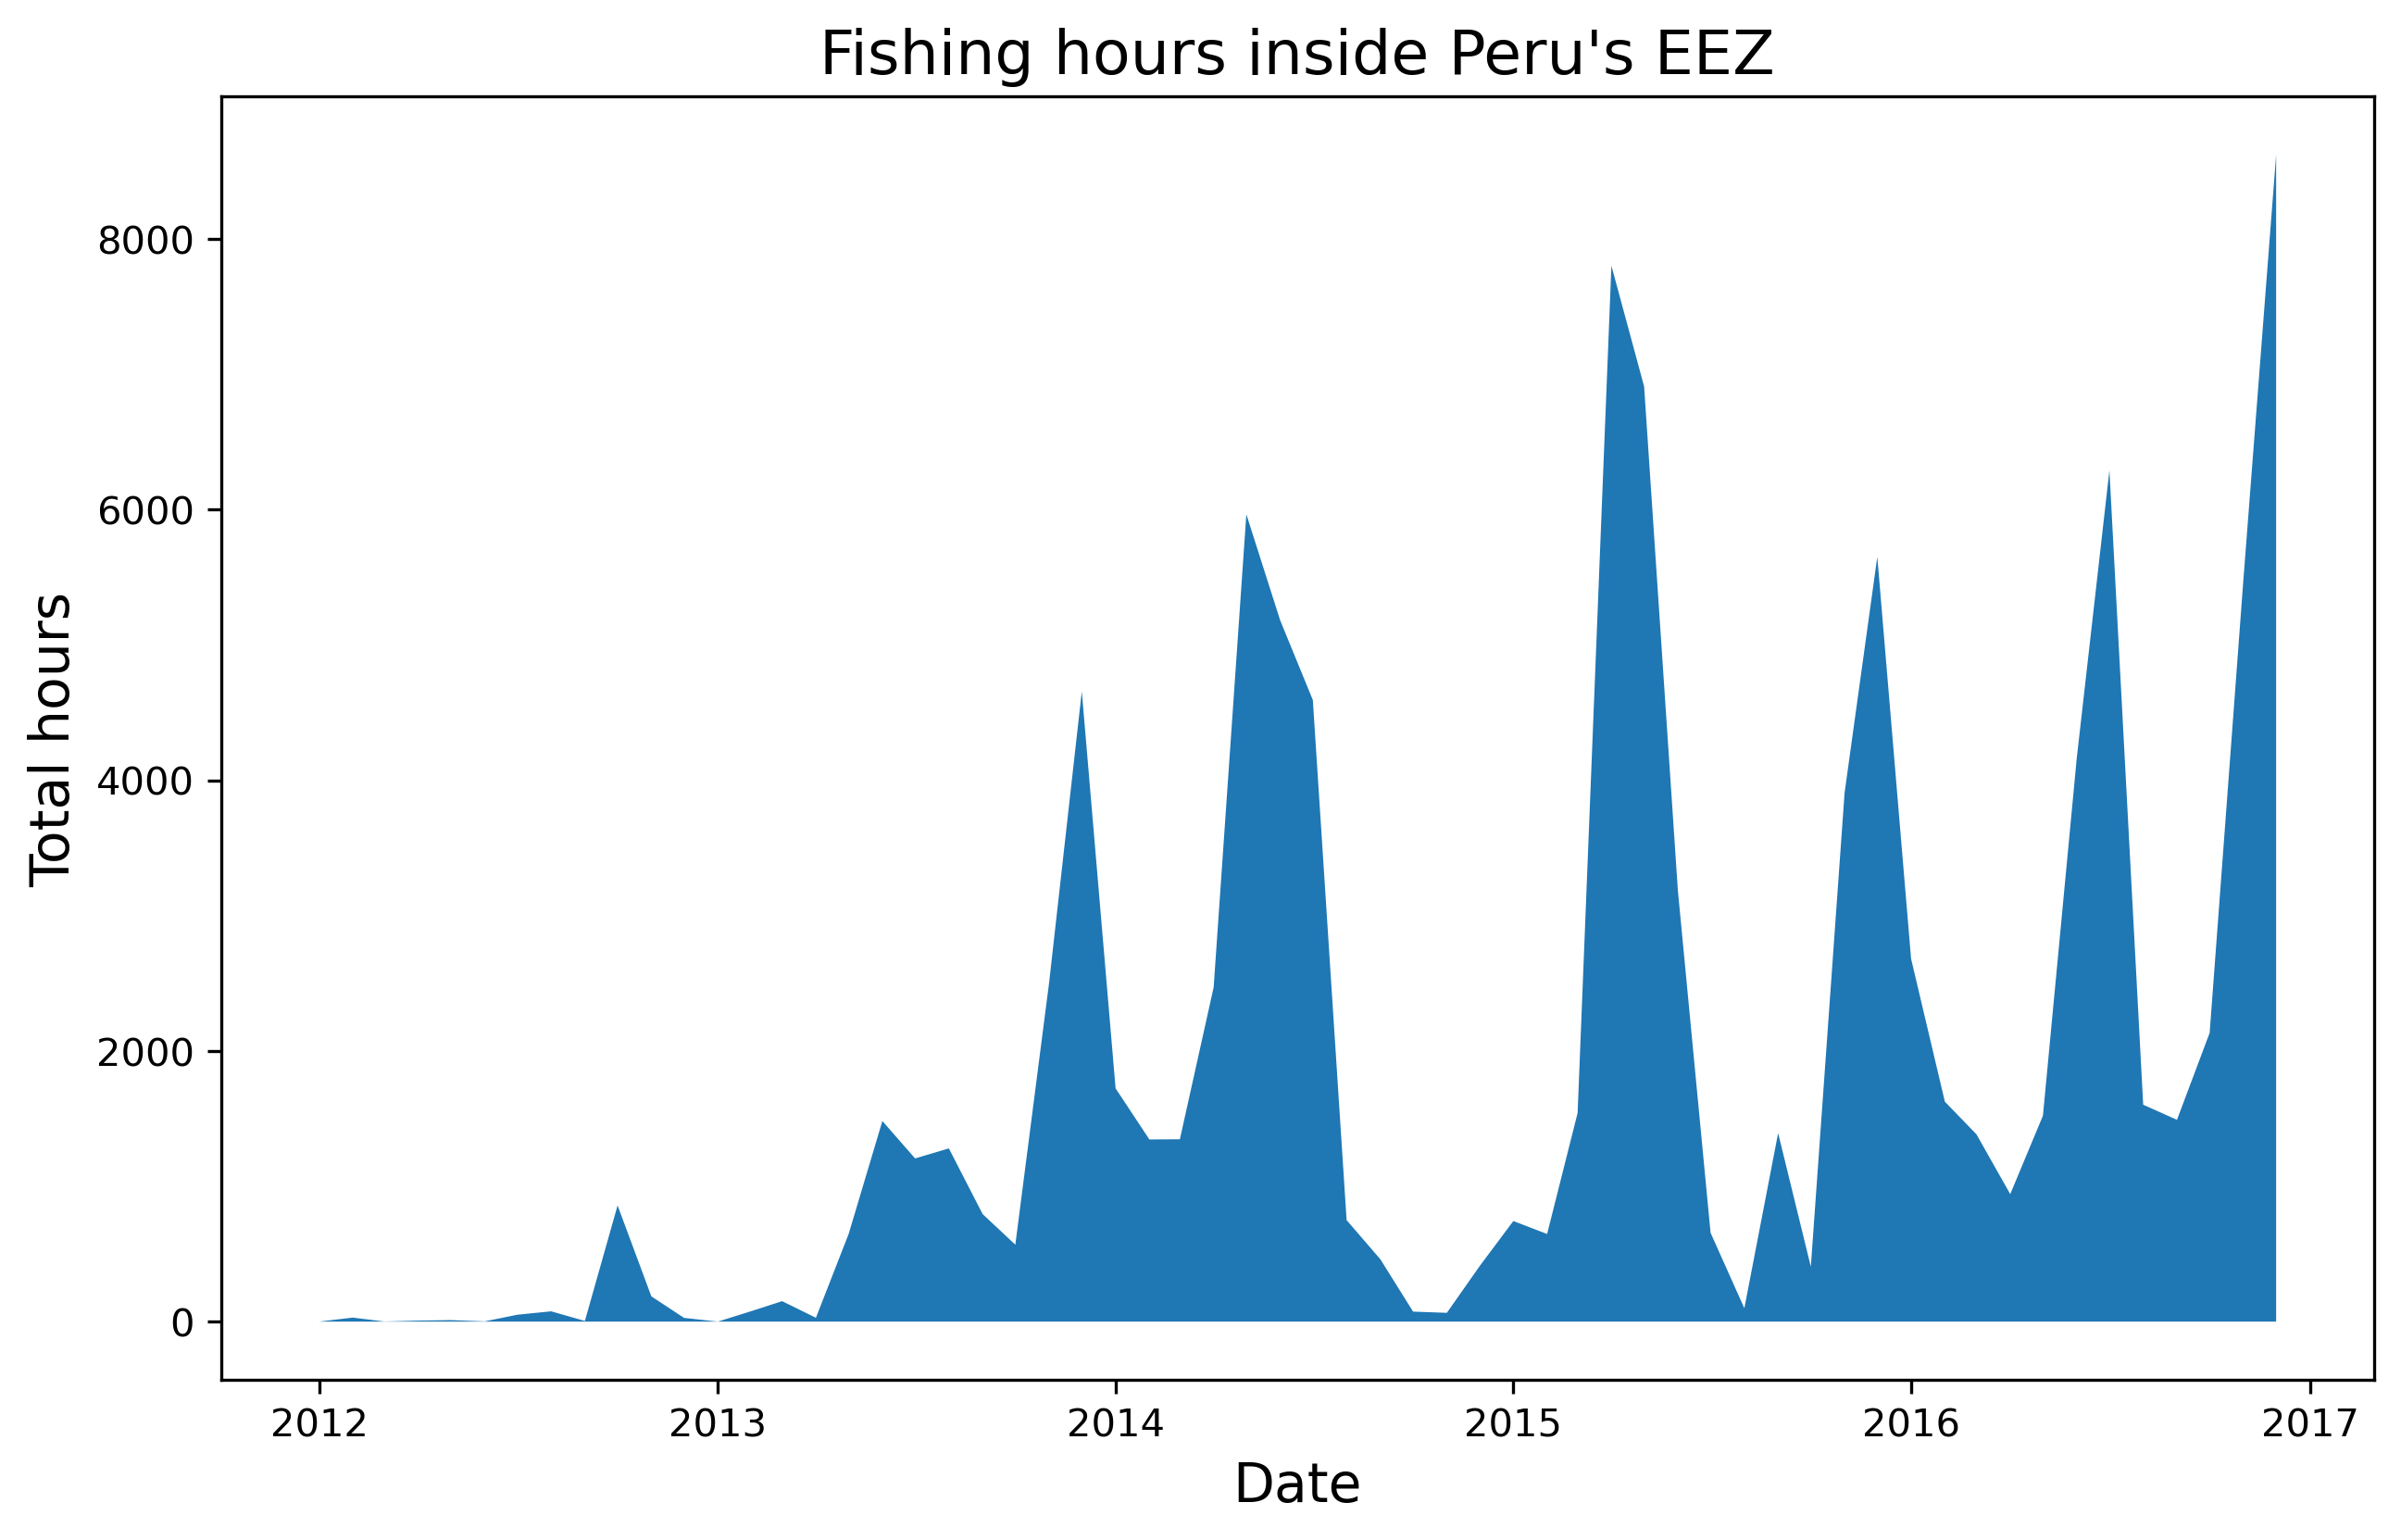

In [26]:
plt.figure(figsize=(10, 6), dpi=300)   # create a new figure, set size and resolution (dpi)
plt.fill_between(df['datetime'],df['total_fishing_hours'])   # add data to the plot
plt.title("Fishing hours inside Peru's EEZ", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total hours', fontsize=14)

#### Fishing outside the EEZ

To characterize the fishing activity outside of the EEZ, we need to define a new area of interest. In this case, we will focus on a square region with the same latitude boundaries as the EEZ but extending towards the west in longitud (`aoi_2`). The first step is to quantify the number of fishing hours over that region. Then we will substract the EEZ fishing hours previously calculated from it to graphically compare effort from inside and outside.

The map below shows the new area of interest and the data across a the 5-year time period that will be included in the time series analysis.

In [31]:
# Fishing effort in Peru's EEZ
effort_AOI2 = fishing_effort_ImgCollection.filterBounds(aoi_2).map(lambda image: image.clip(aoi_2))
## Aggregate 2016 collection to single image of global fishing effort
effort_AOI2 = effort_AOI2.sum()
## Sum bands to get total effort across gear types
effort_AOI2 = effort_AOI2.reduce(ee.Reducer.sum())
## Mask out pixels with no effort
effort_AOI2 = effort_AOI2.mask(effort_AOI2.gt(0))

# Add the total fishing effort layer
Map = geemap.Map(zoom = 2)
Map.centerObject(aoi_2, 5)
Map.setOptions('HYBRID');
Map.addLayer(aoi_2, {'color': 'white','width': 1.5}, "Sampling area");
Map.addLayer(effort_AOI2,trawlersVis);
Map

Map(center=[-11.493252083428661, -79.9759195448968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Text(0, 0.5, 'Total hours')

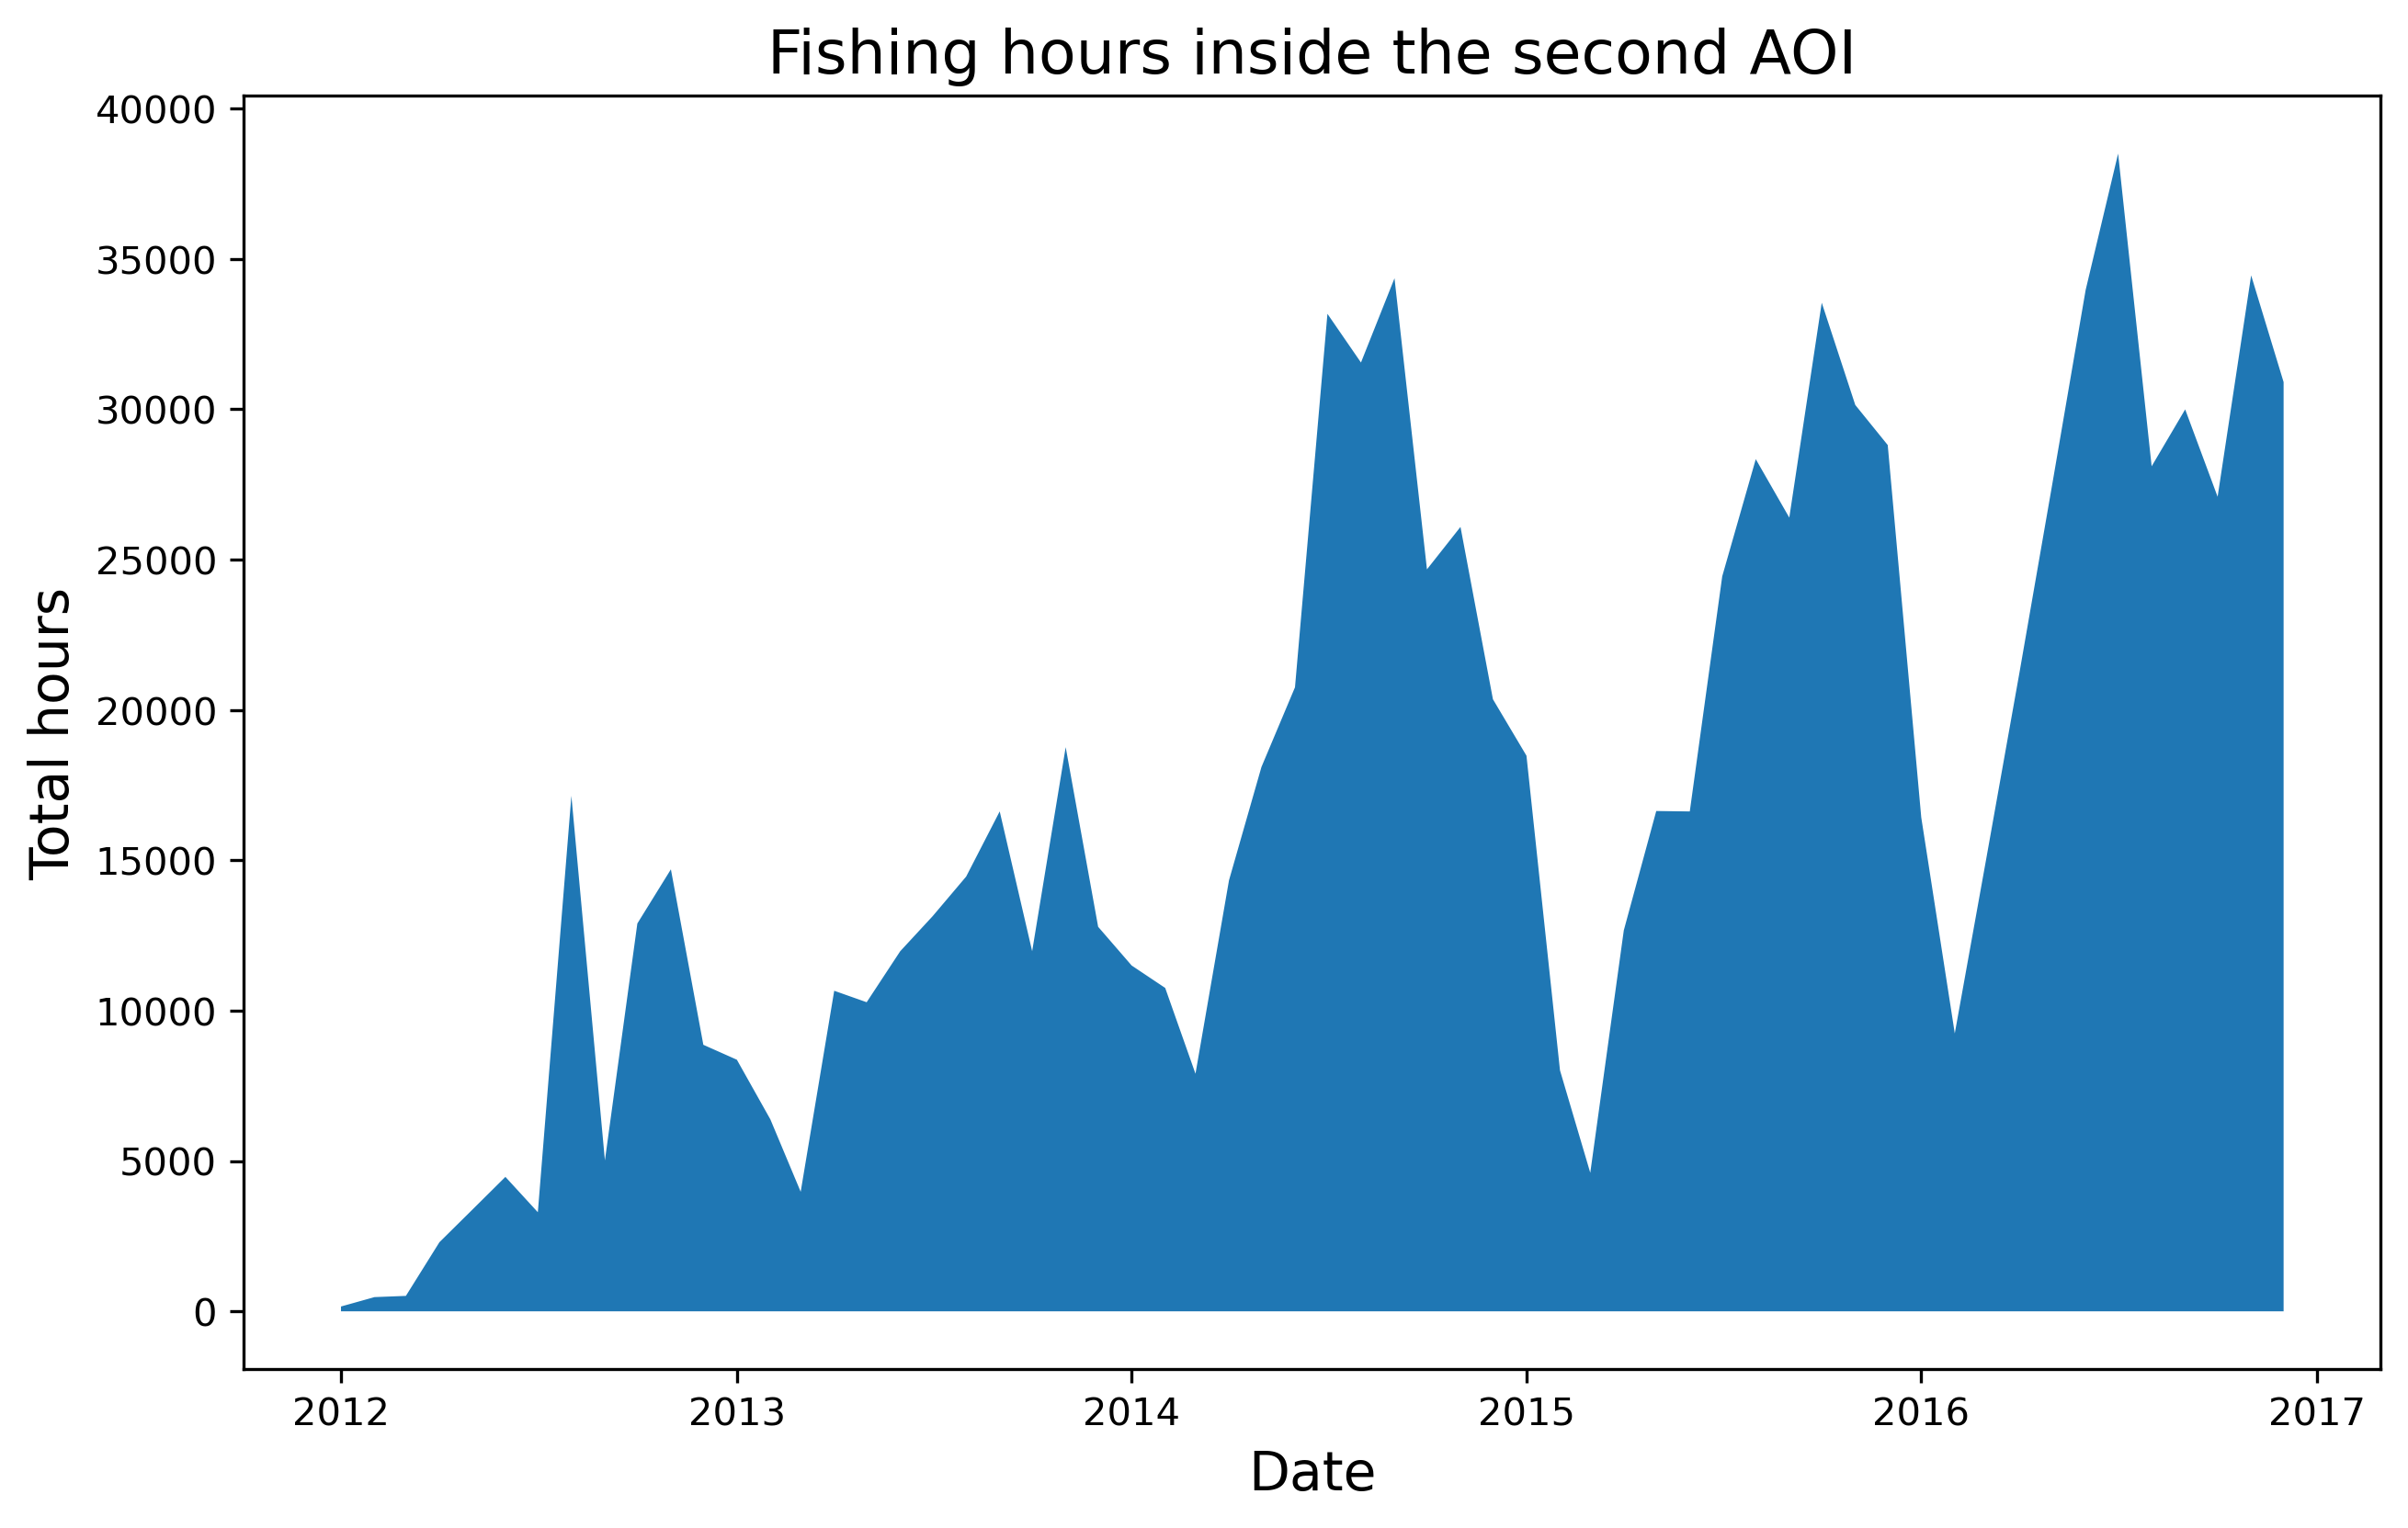

In [28]:
# Function to summarize fishing monthly data inside and outside the EEZ
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi_2, 
                           scale=1113.2)
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

# Converting GEE data to Pandas and rearranging it for its representation
df2 = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df2['sum'] = df2['sum'].apply(lambda x: x.get('sum'))
df2.rename(columns = {'sum':'total_fishing_hours'}, inplace = True)
df2["id"] = df2.index 
first_column = df2.pop('id')
df2.insert(0, 'id', first_column)
df2['datetime'] = pd.to_datetime(df2['time'], unit='ms')
df2['datetime'] = pd.to_datetime(df2['datetime'],format="%Y%m%d")

# Ploting time series
plt.figure(figsize=(10, 6), dpi=300)   
plt.fill_between(df2['datetime'],df2['total_fishing_hours'])
plt.title("Fishing hours inside the second AOI", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total hours', fontsize=14)

To compare fishing efforts within and outside, we can subtract the total fishing hours from the previous dataframes. This will give us the actual fishing effort outside the EEZ, which we can then represent alongside fishing within the EEZ in an area chart for easy visualization and comparison.

In [29]:
# Combining both df
df["total_fishing_hours_outside"] = abs(df["total_fishing_hours"] - df2["total_fishing_hours"])
df.rename(columns = {'total_fishing_hours':'total_fishing_hours_inside'}, inplace = True) 
total_fishing_df = df[['id', 'time', 'datetime','total_fishing_hours_inside','total_fishing_hours_outside']]
total_fishing_df.head()


,id,time,datetime,total_fishing_hours_inside,total_fishing_hours_outside
0,0,1325376000000,2012-01-01,0.000000,160.185273
1,1,1328054400000,2012-02-01,29.597059,442.994487
2,2,1330560000000,2012-03-01,0.683282,512.164755
3,3,1333238400000,2012-04-01,7.479013,2290.269927
4,4,1335830400000,2012-05-01,11.036600,3353.737642


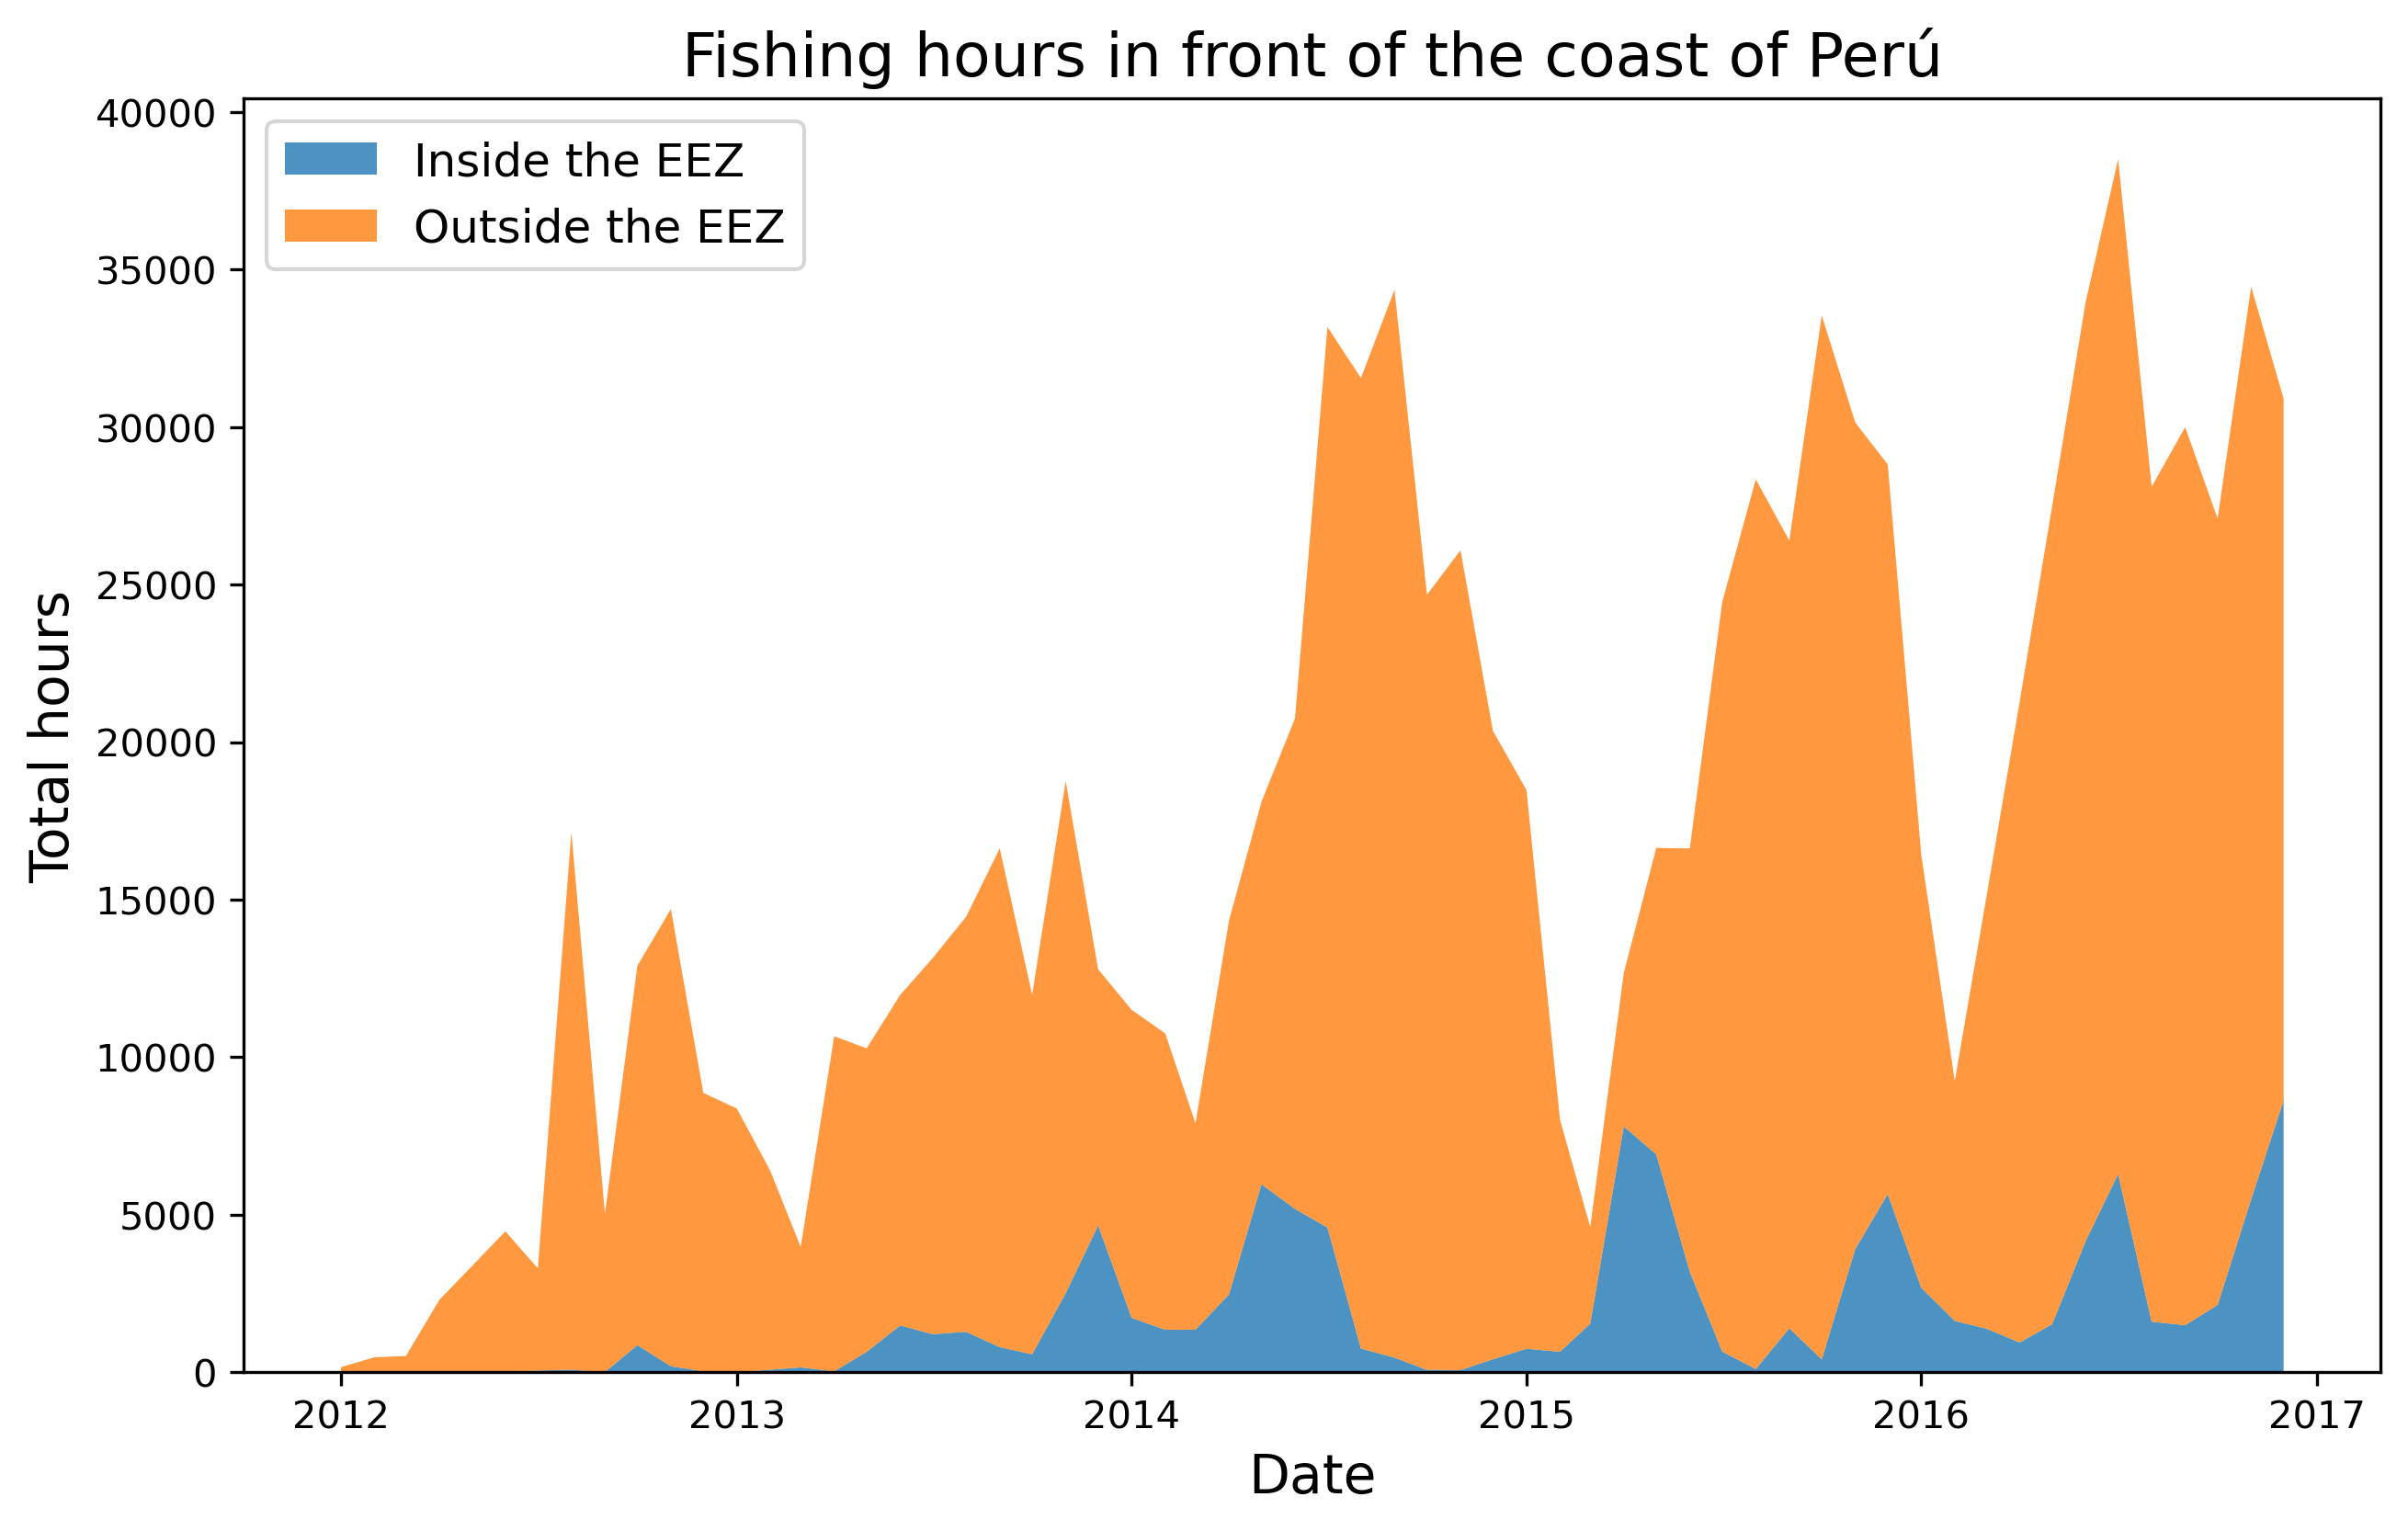

In [30]:
plt.figure(figsize=(10, 6), dpi=300)   
plt.stackplot(total_fishing_df['datetime'],
              [total_fishing_df['total_fishing_hours_inside'], total_fishing_df['total_fishing_hours_outside']],
              labels=['Inside the EEZ', 'Outside the EEZ'],
              alpha=0.8)
plt.title("Fishing hours in front of the coast of Perú", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total hours', fontsize=14)
plt.legend(loc=2, fontsize='large')
plt.show()


The orange region of the graph indicates the amount of fishing occuring in international waters, while the blue area represents the fishing that takes place within Peru's exclusive economic zone (EEZ). It is likely that this fishing is carried out by Peru's own fleet or by other countries with which Peru has bilateral fishing agreements. From the data, it is clear that the majority of fishing effort occurs outside of Peru's EEZ, with some instances exceeding 30,000 hours. This highlights the importance of the EEZ, as it protects Peru's resources from being overexploited by foreign fleets. Without the EEZ, foreign fleets would be able to legally access and deplete Peru's waters.

On the other hand, there is a distinct pattern of fishing activity that tends to peak during the summer and fall months, and decrease during the winter. This trend is consistent both inside and outside the Exclusive Economic Zone (EEZ). Additionally, it appears that there has been an increase in fishing hours when comparing the first two years of data with the last three years. However, this could be attributed to better availability of AIS data over the years rather than any actual changes in fishing patterns. Furthermore, there is no clear evidence of an influence of ENSO events on fishing activity. In fact, values for 2014 and 2015 are relatively similar, indicating that fishing hours may not be the most effective way to measure the impact of atmospheric and oceanic oscillations on fisheries.


### Improving our analysis

Overall, the notebook has successfully introduced the GFW datasets and its access through GEE. However, continuing the analysis could provide further insights into the study case.

We could improve our analysis in several ways. For instance, we could investigate the contribution of different fishing flags to the total fishing effort both inside and outside the EEZ. This would allow us to identify which international fleets are fishing in Peru's waters and evaluate the countries that have fishing agreements with Peru. We could also compare total navigation hours (a dataset also available from GEE) with fishing hours to establish how busy the waters are within our areas of interest.

Furthermore, we could delve deeper into exploring the effects of ENSO. Initially, we could have included a time series of the ENSO indicator from the 3-month mean of ERSST.v5 sea surface temperature anomalies in the Niño 3.4 region, which we did not incorporate as we did not detect any influence. In this regard, we could have explored additional GFW datasets (accessible through Google BigQuery) representing fishing activities using indicators influenced by El Niño.

<a id='binder'></a> 
## Binder Environment

The content of the present notebook can be accessed using Binder's services for building and sharing reproducible and interactive computational environments from online repositories.

Click this link to launch the notebook in your browser:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/EDS220-Fall2022-org/homework-2-mangrove-team.git/HEAD?labpath=peruvian-fisheries-effort.ipynb)

<a id='references'></a> 
## References

1. Christensen, V., de la Puente, S., Sueiro, J. C., Steenbeek, J., & Majluf, P. (2014). Valuing seafood: The Peruvian fisheries sector. Marine Policy, 44, 302–311. https://doi.org/10.1016/j.marpol.2013.09.022

2. El Niño | National Geographic Society. (n.d.). Retrieved November 29, 2022, from https://education.nationalgeographic.org/resource/el-nino

3. FAO. Fishery and Aquaculture Statistics. Global capture production 1950-2020 (FishStatJ). 2022. In: FAO Fisheries and Aquaculture Division [online]. Rome. Updated 2022.

4. GFW (global fishing watch) daily fishing hours | Earth Engine Data catalog | google developers (no date) Google. Google. Available at: https://developers.google.com/earth-engine/datasets/catalog/GFW_GFF_V1_fishing_hours (Accessed: November 30, 2022).

5. Global Fishing Watch Application Programming Interfaces (API) Documentation (https://globalfishingwatch.org/our-apis/documentation#introduction)

6. Kroodsma, David A., Juan Mayorga, Timothy Hochberg, Nathan A. Miller, Kristina Boerder, Francesco Ferretti, Alex Wilson et al. "Tracking the global footprint of fisheries." Science 359, no. 6378 (2018): 904-908. DOI:10.1126/science.aao5646.

